# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
# run this once to unzip the file
# !unzip processed-celeba-small.zip

In [3]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor

import tests


In [4]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [5]:
import torchvision.transforms as T
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list   
    transforms = [T.Resize(size),  
                  T.ToTensor(),   
                  T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [6]:
from torchvision.io import read_image
import os
import itertools
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        # TODO: implement the init method
        self.img_dir = directory
        self.transforms = transforms
        self.extension = extension
        _, _, files = next(os.walk(self.img_dir))
        self.img_labels = list(os.path.join(self.img_dir, file) 
                             for file in files if (self.extension in file))

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return sum(1 for _ in self.img_labels)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        img_path = self.img_labels[index]
        image = Image.open(img_path)
        return self.transforms(image)

In [7]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

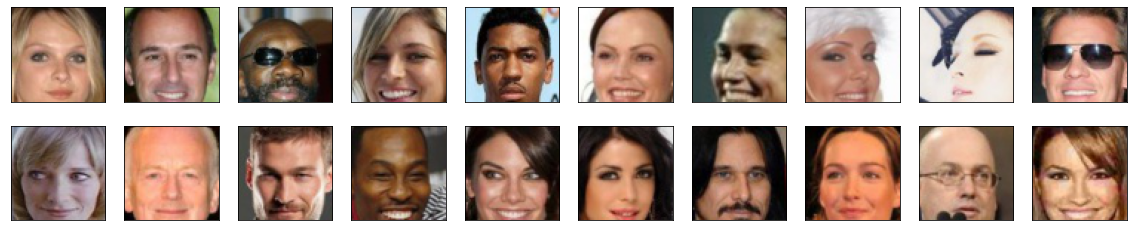

In [8]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:  

* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [9]:
from torch.nn import Module
import torch.nn as nn

In [10]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        conv_dim = 64
        n_channels = 3
        self.main = nn.Sequential(
            nn.Conv2d(n_channels, conv_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(conv_dim, conv_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(conv_dim * 2, conv_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(conv_dim * 4, conv_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(conv_dim * 8, 1, 4, 1, 0, bias=False),
            ## BCELoss func
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
discriminator.apply(weights_init)
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        nz = latent_dim
        nc = 3
        conv_dim = 64
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, conv_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(conv_dim * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(conv_dim * 8, conv_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( conv_dim * 4, conv_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( conv_dim * 2, conv_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(True),
            nn.ConvTranspose2d( conv_dim, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [14]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator()

generator.apply(weights_init)

tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [15]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    d_optimizer = optim.Adam(discriminator.parameters(), lr, [beta1, beta2])
    g_optimizer = optim.Adam(generator.parameters(), lr, [beta1, beta2])
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [16]:
def real_loss(D_out, smooth=True):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss 
    criterion = nn.BCELoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = criterion = nn.BCELoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [17]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    # TODO: implement the generator loss 
    loss= real_loss(fake_logits)
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [18]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # TODO: implement the discriminator loss 
    loss= real_loss(real_logits, smooth= True)+ fake_loss(fake_logits)
    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [19]:
class Critic(nn.Module):
    """ 
    Dummy critic class 
    """
    def __init__(self):
        super(Critic, self).__init__()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.pow(x, 2)
    
def gradient_penalty(real_sample: torch.Tensor, 
                     fake_sample: torch.Tensor) -> torch.Tensor:
    """
    Gradient penalty of the WGAN-GP model
    args:
    - real_sample: sample from the real dataset
    - fake_sample: generated sample
    
    returns:
    - gradient penalty
    """
    # sample a random point between both distributions
       
    alpha = torch.rand(real_sample.shape)
    if train_on_gpu:
        alpha= alpha.cuda()
    alpha.requires_grad = True        
    x_hat = alpha * real_sample + (1 - alpha) * fake_sample
    

    critic = Critic()
    pred = critic(x_hat)
    grad = torch.autograd.grad(pred, 
                               x_hat, 
                               grad_outputs=torch.ones_like(pred), 
                               create_graph=True)[0]
    
    # calculate the norm and the final penalty
    norm = torch.norm(grad.view(-1), 2)
    gp = ((norm - 1)**2).mean()    
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [27]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    
    z= np.random.uniform(-1, 1, size= (batch_size, latent_dim, 1, 1))
    z= torch.from_numpy(z).float()
    if train_on_gpu:
        z= z.cuda()
        
    g_optimizer.zero_grad()
    #  This is 2nd time generator being executed, was executed in D already
    #  Weights already optimzed 
    fake_img= generator(z)
    
    d_output= discriminator(fake_img)
    g_loss= generator_loss(d_output)
    
    g_loss.backward()
    g_optimizer.step()
    
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    
    # z is noise added ??
    z= np.random.uniform(-1, 1, size= (batch_size, latent_dim, 1, 1))
    z= torch.from_numpy(z).float()
    if train_on_gpu:
        z= z.cuda()
        
    d_real_output= discriminator(real_images)
    d_optimizer.zero_grad()
    # weight in generator class already optimized in     
    fake_img= generator(z)
    if train_on_gpu:
        fake_img= fake_img.cuda()
    
    #gp = 0
    # ????? Also, you have to detach the generator output during discriminator training.
    # d_fake_output= discriminator(fake_img)
    # https://discuss.pytorch.org/t/couldnt-understand-how-detach-is-changing-the-generator-working/84637
    #  Detach since we don't wish to add fake_img grident into backwards calculation
    d_fake_output= discriminator(fake_img.detach()).view(-1)
    
    d_loss= discriminator_loss(d_real_output, d_fake_output)
    d_loss.backward()
    d_optimizer.step()
    
    return {'loss': d_loss, 'gp': None}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [28]:
from datetime import datetime

In [29]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 25

# number of images in each batch
batch_size = 64

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    generator.cuda()
    discriminator.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')
  

GPU available for training. Models moved to GPU


In [30]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator().to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [31]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

In [32]:
import pickle as pkl
from datetime import datetime
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(14,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    plt.show()


2023-11-14 11:56:16 | Epoch [1/25] | Batch 0/509 | d_loss: 1.4074 | g_loss: 2.8596
2023-11-14 11:56:21 | Epoch [1/25] | Batch 50/509 | d_loss: 3.0102 | g_loss: 1.9771
2023-11-14 11:56:26 | Epoch [1/25] | Batch 100/509 | d_loss: 2.4972 | g_loss: 3.6698
2023-11-14 11:56:31 | Epoch [1/25] | Batch 150/509 | d_loss: 2.1537 | g_loss: 1.5424
2023-11-14 11:56:35 | Epoch [1/25] | Batch 200/509 | d_loss: 1.4489 | g_loss: 1.7006
2023-11-14 11:56:40 | Epoch [1/25] | Batch 250/509 | d_loss: 1.7676 | g_loss: 0.8907
2023-11-14 11:56:45 | Epoch [1/25] | Batch 300/509 | d_loss: 2.0322 | g_loss: 1.1894
2023-11-14 11:56:50 | Epoch [1/25] | Batch 350/509 | d_loss: 1.5341 | g_loss: 0.8650
2023-11-14 11:56:55 | Epoch [1/25] | Batch 400/509 | d_loss: 1.5121 | g_loss: 1.1401
2023-11-14 11:56:59 | Epoch [1/25] | Batch 450/509 | d_loss: 1.4315 | g_loss: 0.8238
2023-11-14 11:57:04 | Epoch [1/25] | Batch 500/509 | d_loss: 1.5473 | g_loss: 0.8974


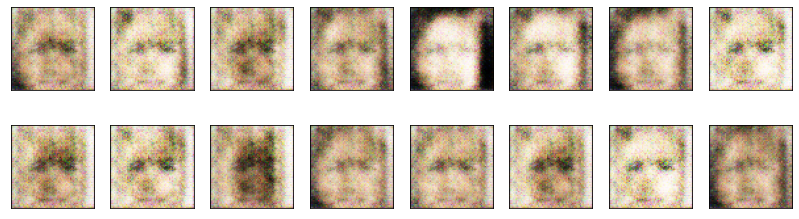

2023-11-14 11:57:08 | Epoch [2/25] | Batch 0/509 | d_loss: 1.3891 | g_loss: 0.9197
2023-11-14 11:57:13 | Epoch [2/25] | Batch 50/509 | d_loss: 1.5376 | g_loss: 0.7875
2023-11-14 11:57:17 | Epoch [2/25] | Batch 100/509 | d_loss: 1.4835 | g_loss: 0.9232
2023-11-14 11:57:22 | Epoch [2/25] | Batch 150/509 | d_loss: 1.6064 | g_loss: 0.7055
2023-11-14 11:57:27 | Epoch [2/25] | Batch 200/509 | d_loss: 1.4292 | g_loss: 0.8488
2023-11-14 11:57:32 | Epoch [2/25] | Batch 250/509 | d_loss: 1.5079 | g_loss: 0.8392
2023-11-14 11:57:37 | Epoch [2/25] | Batch 300/509 | d_loss: 1.4545 | g_loss: 0.8825
2023-11-14 11:57:42 | Epoch [2/25] | Batch 350/509 | d_loss: 1.5054 | g_loss: 0.8495
2023-11-14 11:57:47 | Epoch [2/25] | Batch 400/509 | d_loss: 1.5729 | g_loss: 0.8659
2023-11-14 11:57:51 | Epoch [2/25] | Batch 450/509 | d_loss: 1.4944 | g_loss: 0.7835
2023-11-14 11:57:56 | Epoch [2/25] | Batch 500/509 | d_loss: 1.4909 | g_loss: 0.8598


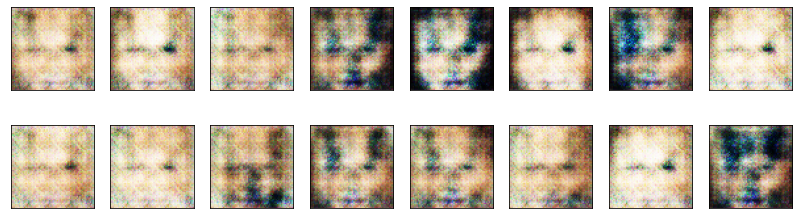

2023-11-14 11:58:01 | Epoch [3/25] | Batch 0/509 | d_loss: 1.4807 | g_loss: 0.9660
2023-11-14 11:58:06 | Epoch [3/25] | Batch 50/509 | d_loss: 1.4785 | g_loss: 0.8391
2023-11-14 11:58:11 | Epoch [3/25] | Batch 100/509 | d_loss: 1.4902 | g_loss: 0.8626
2023-11-14 11:58:16 | Epoch [3/25] | Batch 150/509 | d_loss: 1.5256 | g_loss: 0.8035
2023-11-14 11:58:21 | Epoch [3/25] | Batch 200/509 | d_loss: 1.4044 | g_loss: 0.8353
2023-11-14 11:58:26 | Epoch [3/25] | Batch 250/509 | d_loss: 1.5264 | g_loss: 0.7843
2023-11-14 11:58:31 | Epoch [3/25] | Batch 300/509 | d_loss: 1.4599 | g_loss: 0.7798
2023-11-14 11:58:35 | Epoch [3/25] | Batch 350/509 | d_loss: 1.4907 | g_loss: 0.8146
2023-11-14 11:58:40 | Epoch [3/25] | Batch 400/509 | d_loss: 1.5148 | g_loss: 0.8443
2023-11-14 11:58:45 | Epoch [3/25] | Batch 450/509 | d_loss: 1.4778 | g_loss: 0.9061
2023-11-14 11:58:49 | Epoch [3/25] | Batch 500/509 | d_loss: 1.4987 | g_loss: 0.9558


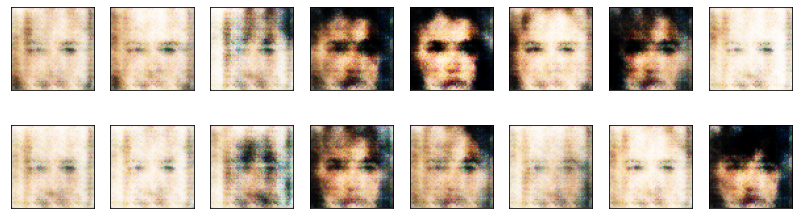

2023-11-14 11:58:55 | Epoch [4/25] | Batch 0/509 | d_loss: 1.3600 | g_loss: 0.9191
2023-11-14 11:58:59 | Epoch [4/25] | Batch 50/509 | d_loss: 1.4506 | g_loss: 0.8034
2023-11-14 11:59:04 | Epoch [4/25] | Batch 100/509 | d_loss: 1.4462 | g_loss: 0.8675
2023-11-14 11:59:09 | Epoch [4/25] | Batch 150/509 | d_loss: 1.4559 | g_loss: 0.8936
2023-11-14 11:59:14 | Epoch [4/25] | Batch 200/509 | d_loss: 1.5222 | g_loss: 0.8862
2023-11-14 11:59:18 | Epoch [4/25] | Batch 250/509 | d_loss: 1.5306 | g_loss: 0.8647
2023-11-14 11:59:23 | Epoch [4/25] | Batch 300/509 | d_loss: 1.4311 | g_loss: 0.8485
2023-11-14 11:59:28 | Epoch [4/25] | Batch 350/509 | d_loss: 1.5268 | g_loss: 0.7398
2023-11-14 11:59:32 | Epoch [4/25] | Batch 400/509 | d_loss: 1.4596 | g_loss: 0.7967
2023-11-14 11:59:37 | Epoch [4/25] | Batch 450/509 | d_loss: 1.4508 | g_loss: 0.7314
2023-11-14 11:59:42 | Epoch [4/25] | Batch 500/509 | d_loss: 1.4180 | g_loss: 0.8126


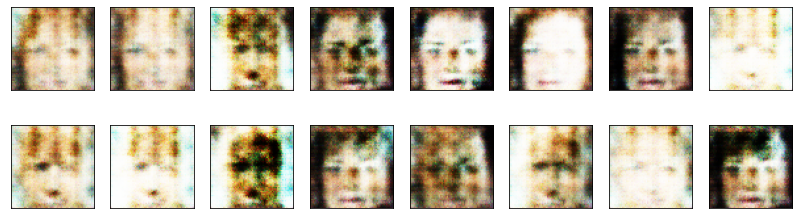

2023-11-14 11:59:47 | Epoch [5/25] | Batch 0/509 | d_loss: 1.3432 | g_loss: 0.8938
2023-11-14 11:59:51 | Epoch [5/25] | Batch 50/509 | d_loss: 1.4167 | g_loss: 0.7900
2023-11-14 11:59:56 | Epoch [5/25] | Batch 100/509 | d_loss: 1.4446 | g_loss: 0.8293
2023-11-14 12:00:01 | Epoch [5/25] | Batch 150/509 | d_loss: 1.4279 | g_loss: 0.7887
2023-11-14 12:00:06 | Epoch [5/25] | Batch 200/509 | d_loss: 1.4273 | g_loss: 0.8073
2023-11-14 12:00:11 | Epoch [5/25] | Batch 250/509 | d_loss: 1.4287 | g_loss: 0.8438
2023-11-14 12:00:16 | Epoch [5/25] | Batch 300/509 | d_loss: 1.4405 | g_loss: 0.8334
2023-11-14 12:00:21 | Epoch [5/25] | Batch 350/509 | d_loss: 1.4376 | g_loss: 0.8206
2023-11-14 12:00:27 | Epoch [5/25] | Batch 400/509 | d_loss: 1.4614 | g_loss: 0.7909
2023-11-14 12:00:32 | Epoch [5/25] | Batch 450/509 | d_loss: 1.4090 | g_loss: 0.8050
2023-11-14 12:00:36 | Epoch [5/25] | Batch 500/509 | d_loss: 1.4492 | g_loss: 0.7772


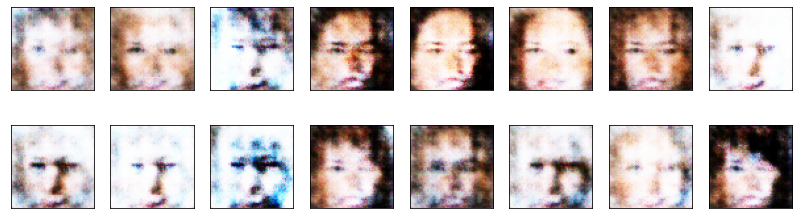

2023-11-14 12:00:42 | Epoch [6/25] | Batch 0/509 | d_loss: 1.3943 | g_loss: 0.8246
2023-11-14 12:00:47 | Epoch [6/25] | Batch 50/509 | d_loss: 1.4187 | g_loss: 0.7606
2023-11-14 12:00:52 | Epoch [6/25] | Batch 100/509 | d_loss: 1.3949 | g_loss: 0.7964
2023-11-14 12:00:56 | Epoch [6/25] | Batch 150/509 | d_loss: 1.4730 | g_loss: 0.8046
2023-11-14 12:01:01 | Epoch [6/25] | Batch 200/509 | d_loss: 1.4517 | g_loss: 0.8281
2023-11-14 12:01:06 | Epoch [6/25] | Batch 250/509 | d_loss: 1.4238 | g_loss: 0.8438
2023-11-14 12:01:11 | Epoch [6/25] | Batch 300/509 | d_loss: 1.4517 | g_loss: 0.8264
2023-11-14 12:01:15 | Epoch [6/25] | Batch 350/509 | d_loss: 1.4513 | g_loss: 0.7828
2023-11-14 12:01:20 | Epoch [6/25] | Batch 400/509 | d_loss: 1.4227 | g_loss: 0.8472
2023-11-14 12:01:25 | Epoch [6/25] | Batch 450/509 | d_loss: 1.4279 | g_loss: 0.8087
2023-11-14 12:01:30 | Epoch [6/25] | Batch 500/509 | d_loss: 1.4344 | g_loss: 0.8404


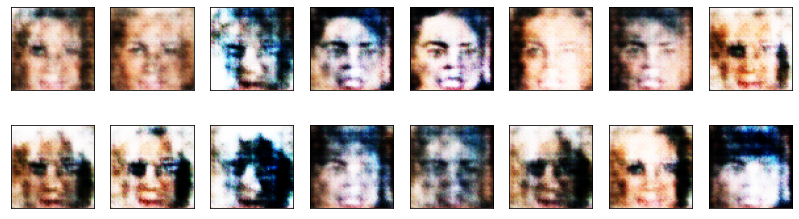

2023-11-14 12:01:34 | Epoch [7/25] | Batch 0/509 | d_loss: 1.3535 | g_loss: 0.8716
2023-11-14 12:01:39 | Epoch [7/25] | Batch 50/509 | d_loss: 1.4596 | g_loss: 0.7357
2023-11-14 12:01:43 | Epoch [7/25] | Batch 100/509 | d_loss: 1.3923 | g_loss: 0.8289
2023-11-14 12:01:48 | Epoch [7/25] | Batch 150/509 | d_loss: 1.4746 | g_loss: 0.8222
2023-11-14 12:01:53 | Epoch [7/25] | Batch 200/509 | d_loss: 1.4167 | g_loss: 0.8388
2023-11-14 12:01:58 | Epoch [7/25] | Batch 250/509 | d_loss: 1.4345 | g_loss: 0.7485
2023-11-14 12:02:03 | Epoch [7/25] | Batch 300/509 | d_loss: 1.4024 | g_loss: 0.8556
2023-11-14 12:02:07 | Epoch [7/25] | Batch 350/509 | d_loss: 1.3903 | g_loss: 0.8066
2023-11-14 12:02:12 | Epoch [7/25] | Batch 400/509 | d_loss: 1.4319 | g_loss: 0.7608
2023-11-14 12:02:17 | Epoch [7/25] | Batch 450/509 | d_loss: 1.4361 | g_loss: 0.7890
2023-11-14 12:02:22 | Epoch [7/25] | Batch 500/509 | d_loss: 1.4655 | g_loss: 0.7907


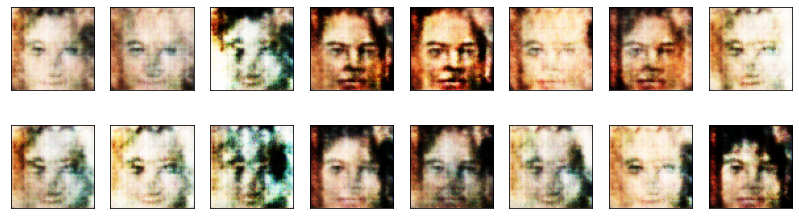

2023-11-14 12:02:27 | Epoch [8/25] | Batch 0/509 | d_loss: 1.3737 | g_loss: 0.8610
2023-11-14 12:02:32 | Epoch [8/25] | Batch 50/509 | d_loss: 1.3871 | g_loss: 0.7226
2023-11-14 12:02:37 | Epoch [8/25] | Batch 100/509 | d_loss: 1.4388 | g_loss: 0.7894
2023-11-14 12:02:42 | Epoch [8/25] | Batch 150/509 | d_loss: 1.3987 | g_loss: 0.7686
2023-11-14 12:02:47 | Epoch [8/25] | Batch 200/509 | d_loss: 1.4101 | g_loss: 0.8457
2023-11-14 12:02:51 | Epoch [8/25] | Batch 250/509 | d_loss: 1.3855 | g_loss: 0.8307
2023-11-14 12:02:56 | Epoch [8/25] | Batch 300/509 | d_loss: 1.3995 | g_loss: 0.8369
2023-11-14 12:03:01 | Epoch [8/25] | Batch 350/509 | d_loss: 1.4338 | g_loss: 0.7484
2023-11-14 12:03:06 | Epoch [8/25] | Batch 400/509 | d_loss: 1.3950 | g_loss: 0.8250
2023-11-14 12:03:10 | Epoch [8/25] | Batch 450/509 | d_loss: 1.4254 | g_loss: 0.7816
2023-11-14 12:03:15 | Epoch [8/25] | Batch 500/509 | d_loss: 1.4513 | g_loss: 0.7514


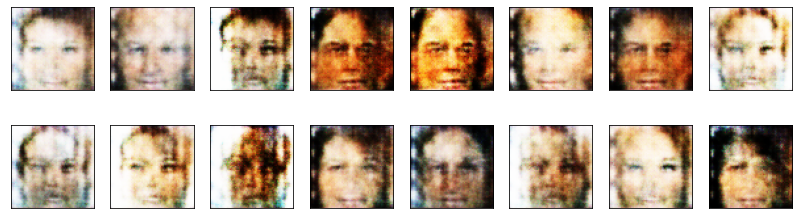

2023-11-14 12:03:20 | Epoch [9/25] | Batch 0/509 | d_loss: 1.3645 | g_loss: 0.8209
2023-11-14 12:03:25 | Epoch [9/25] | Batch 50/509 | d_loss: 1.4250 | g_loss: 0.7452
2023-11-14 12:03:30 | Epoch [9/25] | Batch 100/509 | d_loss: 1.4327 | g_loss: 0.7848
2023-11-14 12:03:35 | Epoch [9/25] | Batch 150/509 | d_loss: 1.3980 | g_loss: 0.8321
2023-11-14 12:03:39 | Epoch [9/25] | Batch 200/509 | d_loss: 1.4217 | g_loss: 0.8275
2023-11-14 12:03:44 | Epoch [9/25] | Batch 250/509 | d_loss: 1.4397 | g_loss: 0.7355
2023-11-14 12:03:49 | Epoch [9/25] | Batch 300/509 | d_loss: 1.3864 | g_loss: 0.8171
2023-11-14 12:03:53 | Epoch [9/25] | Batch 350/509 | d_loss: 1.4582 | g_loss: 0.8331
2023-11-14 12:03:58 | Epoch [9/25] | Batch 400/509 | d_loss: 1.4601 | g_loss: 0.8034
2023-11-14 12:04:03 | Epoch [9/25] | Batch 450/509 | d_loss: 1.4221 | g_loss: 0.7993
2023-11-14 12:04:07 | Epoch [9/25] | Batch 500/509 | d_loss: 1.4170 | g_loss: 0.7668


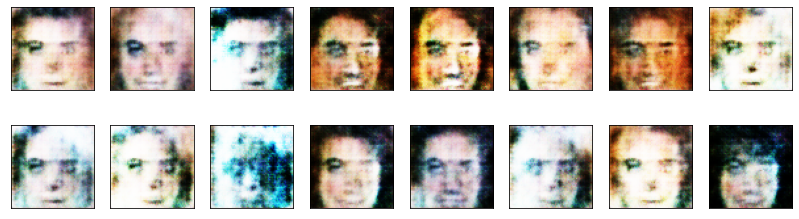

2023-11-14 12:04:11 | Epoch [10/25] | Batch 0/509 | d_loss: 1.3771 | g_loss: 0.8310
2023-11-14 12:04:16 | Epoch [10/25] | Batch 50/509 | d_loss: 1.4454 | g_loss: 0.8581
2023-11-14 12:04:21 | Epoch [10/25] | Batch 100/509 | d_loss: 1.3950 | g_loss: 0.8359
2023-11-14 12:04:26 | Epoch [10/25] | Batch 150/509 | d_loss: 1.4447 | g_loss: 0.7819
2023-11-14 12:04:31 | Epoch [10/25] | Batch 200/509 | d_loss: 1.4430 | g_loss: 0.8360
2023-11-14 12:04:36 | Epoch [10/25] | Batch 250/509 | d_loss: 1.4297 | g_loss: 0.7669
2023-11-14 12:04:40 | Epoch [10/25] | Batch 300/509 | d_loss: 1.4257 | g_loss: 0.7484
2023-11-14 12:04:45 | Epoch [10/25] | Batch 350/509 | d_loss: 1.4149 | g_loss: 0.7518
2023-11-14 12:04:50 | Epoch [10/25] | Batch 400/509 | d_loss: 1.4137 | g_loss: 0.8624
2023-11-14 12:04:55 | Epoch [10/25] | Batch 450/509 | d_loss: 1.4414 | g_loss: 0.8101
2023-11-14 12:05:00 | Epoch [10/25] | Batch 500/509 | d_loss: 1.4229 | g_loss: 0.8447


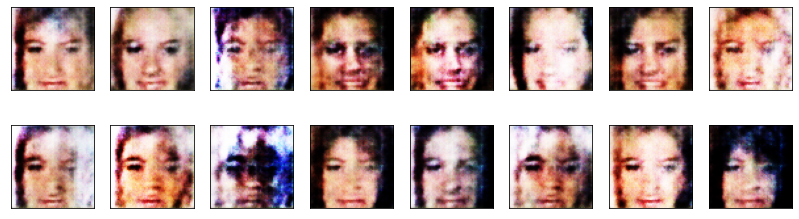

2023-11-14 12:05:05 | Epoch [11/25] | Batch 0/509 | d_loss: 1.4296 | g_loss: 0.8249
2023-11-14 12:05:10 | Epoch [11/25] | Batch 50/509 | d_loss: 1.4046 | g_loss: 0.7776
2023-11-14 12:05:15 | Epoch [11/25] | Batch 100/509 | d_loss: 1.4048 | g_loss: 0.7859
2023-11-14 12:05:19 | Epoch [11/25] | Batch 150/509 | d_loss: 1.4001 | g_loss: 0.7809
2023-11-14 12:05:24 | Epoch [11/25] | Batch 200/509 | d_loss: 1.4133 | g_loss: 0.8321
2023-11-14 12:05:28 | Epoch [11/25] | Batch 250/509 | d_loss: 1.4252 | g_loss: 0.7926
2023-11-14 12:05:33 | Epoch [11/25] | Batch 300/509 | d_loss: 1.4320 | g_loss: 0.8427
2023-11-14 12:05:38 | Epoch [11/25] | Batch 350/509 | d_loss: 1.4218 | g_loss: 0.8030
2023-11-14 12:05:43 | Epoch [11/25] | Batch 400/509 | d_loss: 1.4164 | g_loss: 0.7460
2023-11-14 12:05:48 | Epoch [11/25] | Batch 450/509 | d_loss: 1.4346 | g_loss: 0.7699
2023-11-14 12:05:52 | Epoch [11/25] | Batch 500/509 | d_loss: 1.4118 | g_loss: 0.8070


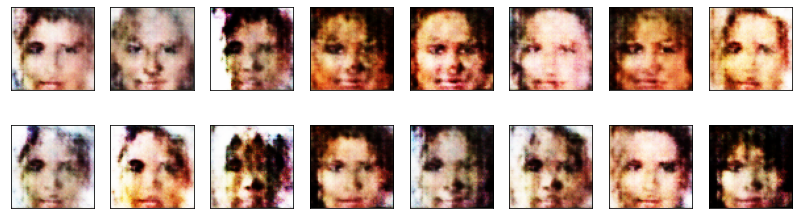

2023-11-14 12:05:57 | Epoch [12/25] | Batch 0/509 | d_loss: 1.4046 | g_loss: 0.8065
2023-11-14 12:06:01 | Epoch [12/25] | Batch 50/509 | d_loss: 1.3974 | g_loss: 0.7862
2023-11-14 12:06:06 | Epoch [12/25] | Batch 100/509 | d_loss: 1.4168 | g_loss: 0.8025
2023-11-14 12:06:11 | Epoch [12/25] | Batch 150/509 | d_loss: 1.4011 | g_loss: 0.7519
2023-11-14 12:06:15 | Epoch [12/25] | Batch 200/509 | d_loss: 1.3972 | g_loss: 0.7969
2023-11-14 12:06:20 | Epoch [12/25] | Batch 250/509 | d_loss: 1.4093 | g_loss: 0.7783
2023-11-14 12:06:25 | Epoch [12/25] | Batch 300/509 | d_loss: 1.4045 | g_loss: 0.8000
2023-11-14 12:06:30 | Epoch [12/25] | Batch 350/509 | d_loss: 1.4140 | g_loss: 0.7766
2023-11-14 12:06:34 | Epoch [12/25] | Batch 400/509 | d_loss: 1.3930 | g_loss: 0.8313
2023-11-14 12:06:39 | Epoch [12/25] | Batch 450/509 | d_loss: 1.4010 | g_loss: 0.8412
2023-11-14 12:06:44 | Epoch [12/25] | Batch 500/509 | d_loss: 1.4163 | g_loss: 0.7959


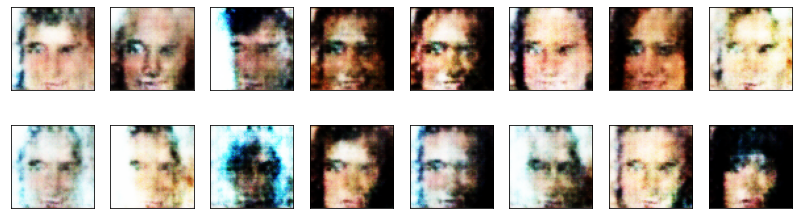

2023-11-14 12:06:48 | Epoch [13/25] | Batch 0/509 | d_loss: 1.3960 | g_loss: 0.7971
2023-11-14 12:06:53 | Epoch [13/25] | Batch 50/509 | d_loss: 1.4211 | g_loss: 0.7575
2023-11-14 12:06:58 | Epoch [13/25] | Batch 100/509 | d_loss: 1.4308 | g_loss: 0.8241
2023-11-14 12:07:03 | Epoch [13/25] | Batch 150/509 | d_loss: 1.4373 | g_loss: 0.7495
2023-11-14 12:07:07 | Epoch [13/25] | Batch 200/509 | d_loss: 1.4138 | g_loss: 0.7809
2023-11-14 12:07:12 | Epoch [13/25] | Batch 250/509 | d_loss: 1.4302 | g_loss: 0.8038
2023-11-14 12:07:17 | Epoch [13/25] | Batch 300/509 | d_loss: 1.4057 | g_loss: 0.7740
2023-11-14 12:07:22 | Epoch [13/25] | Batch 350/509 | d_loss: 1.4047 | g_loss: 0.7695
2023-11-14 12:07:26 | Epoch [13/25] | Batch 400/509 | d_loss: 1.4158 | g_loss: 0.8223
2023-11-14 12:07:31 | Epoch [13/25] | Batch 450/509 | d_loss: 1.4220 | g_loss: 0.8421
2023-11-14 12:07:35 | Epoch [13/25] | Batch 500/509 | d_loss: 1.3938 | g_loss: 0.8145


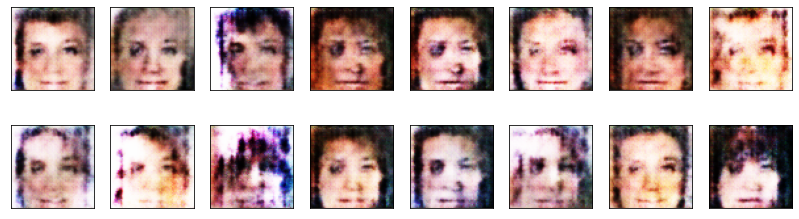

2023-11-14 12:07:40 | Epoch [14/25] | Batch 0/509 | d_loss: 1.3860 | g_loss: 0.8329
2023-11-14 12:07:45 | Epoch [14/25] | Batch 50/509 | d_loss: 1.3913 | g_loss: 0.7981
2023-11-14 12:07:50 | Epoch [14/25] | Batch 100/509 | d_loss: 1.3958 | g_loss: 0.8080
2023-11-14 12:07:55 | Epoch [14/25] | Batch 150/509 | d_loss: 1.4097 | g_loss: 0.7959
2023-11-14 12:07:59 | Epoch [14/25] | Batch 200/509 | d_loss: 1.4055 | g_loss: 0.8490
2023-11-14 12:08:04 | Epoch [14/25] | Batch 250/509 | d_loss: 1.4406 | g_loss: 0.7595
2023-11-14 12:08:09 | Epoch [14/25] | Batch 300/509 | d_loss: 1.4148 | g_loss: 0.8040
2023-11-14 12:08:13 | Epoch [14/25] | Batch 350/509 | d_loss: 1.4252 | g_loss: 0.7840
2023-11-14 12:08:18 | Epoch [14/25] | Batch 400/509 | d_loss: 1.4048 | g_loss: 0.7684
2023-11-14 12:08:22 | Epoch [14/25] | Batch 450/509 | d_loss: 1.4139 | g_loss: 0.7910
2023-11-14 12:08:27 | Epoch [14/25] | Batch 500/509 | d_loss: 1.4002 | g_loss: 0.7693


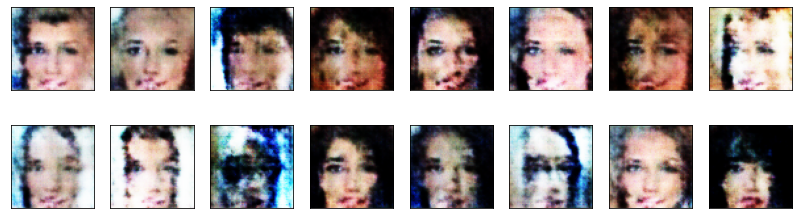

2023-11-14 12:08:31 | Epoch [15/25] | Batch 0/509 | d_loss: 1.3663 | g_loss: 0.8680
2023-11-14 12:08:36 | Epoch [15/25] | Batch 50/509 | d_loss: 1.4191 | g_loss: 0.8053
2023-11-14 12:08:41 | Epoch [15/25] | Batch 100/509 | d_loss: 1.4306 | g_loss: 0.7791
2023-11-14 12:08:46 | Epoch [15/25] | Batch 150/509 | d_loss: 1.4141 | g_loss: 0.7796
2023-11-14 12:08:50 | Epoch [15/25] | Batch 200/509 | d_loss: 1.4378 | g_loss: 0.8079
2023-11-14 12:08:55 | Epoch [15/25] | Batch 250/509 | d_loss: 1.4012 | g_loss: 0.7990
2023-11-14 12:09:00 | Epoch [15/25] | Batch 300/509 | d_loss: 1.3995 | g_loss: 0.7918
2023-11-14 12:09:05 | Epoch [15/25] | Batch 350/509 | d_loss: 1.4096 | g_loss: 0.7576
2023-11-14 12:09:09 | Epoch [15/25] | Batch 400/509 | d_loss: 1.4078 | g_loss: 0.8138
2023-11-14 12:09:14 | Epoch [15/25] | Batch 450/509 | d_loss: 1.4221 | g_loss: 0.7794
2023-11-14 12:09:19 | Epoch [15/25] | Batch 500/509 | d_loss: 1.4470 | g_loss: 0.7579


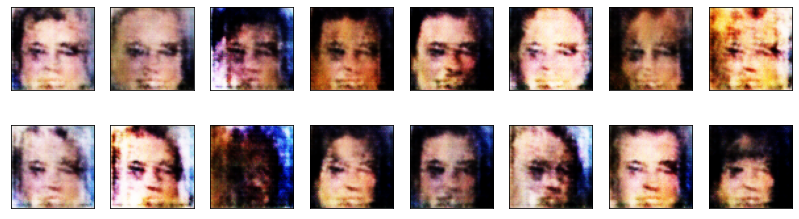

2023-11-14 12:09:23 | Epoch [16/25] | Batch 0/509 | d_loss: 1.3603 | g_loss: 0.8418
2023-11-14 12:09:28 | Epoch [16/25] | Batch 50/509 | d_loss: 1.4698 | g_loss: 0.7319
2023-11-14 12:09:33 | Epoch [16/25] | Batch 100/509 | d_loss: 1.4395 | g_loss: 0.8237
2023-11-14 12:09:38 | Epoch [16/25] | Batch 150/509 | d_loss: 1.4096 | g_loss: 0.7721
2023-11-14 12:09:42 | Epoch [16/25] | Batch 200/509 | d_loss: 1.3977 | g_loss: 0.8124
2023-11-14 12:09:47 | Epoch [16/25] | Batch 250/509 | d_loss: 1.4088 | g_loss: 0.7799
2023-11-14 12:09:52 | Epoch [16/25] | Batch 300/509 | d_loss: 1.4071 | g_loss: 0.8116
2023-11-14 12:09:56 | Epoch [16/25] | Batch 350/509 | d_loss: 1.4081 | g_loss: 0.7756
2023-11-14 12:10:01 | Epoch [16/25] | Batch 400/509 | d_loss: 1.4387 | g_loss: 0.7892
2023-11-14 12:10:06 | Epoch [16/25] | Batch 450/509 | d_loss: 1.4081 | g_loss: 0.7737
2023-11-14 12:10:10 | Epoch [16/25] | Batch 500/509 | d_loss: 1.4439 | g_loss: 0.7618


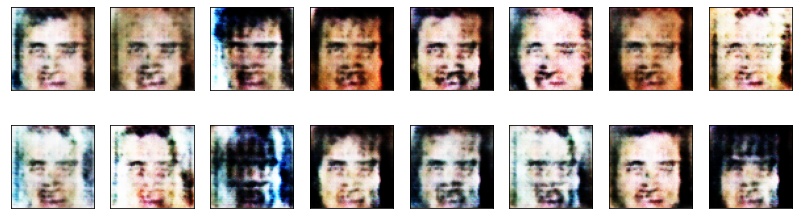

2023-11-14 12:10:14 | Epoch [17/25] | Batch 0/509 | d_loss: 1.3645 | g_loss: 0.8433
2023-11-14 12:10:19 | Epoch [17/25] | Batch 50/509 | d_loss: 1.3896 | g_loss: 0.7575
2023-11-14 12:10:23 | Epoch [17/25] | Batch 100/509 | d_loss: 1.4211 | g_loss: 0.8052
2023-11-14 12:10:28 | Epoch [17/25] | Batch 150/509 | d_loss: 1.4099 | g_loss: 0.7704
2023-11-14 12:10:33 | Epoch [17/25] | Batch 200/509 | d_loss: 1.3981 | g_loss: 0.7859
2023-11-14 12:10:37 | Epoch [17/25] | Batch 250/509 | d_loss: 1.4081 | g_loss: 0.7811
2023-11-14 12:10:42 | Epoch [17/25] | Batch 300/509 | d_loss: 1.4165 | g_loss: 0.7831
2023-11-14 12:10:47 | Epoch [17/25] | Batch 350/509 | d_loss: 1.3914 | g_loss: 0.7530
2023-11-14 12:10:52 | Epoch [17/25] | Batch 400/509 | d_loss: 1.4114 | g_loss: 0.8290
2023-11-14 12:10:57 | Epoch [17/25] | Batch 450/509 | d_loss: 1.3881 | g_loss: 0.7596
2023-11-14 12:11:02 | Epoch [17/25] | Batch 500/509 | d_loss: 1.4262 | g_loss: 0.8098


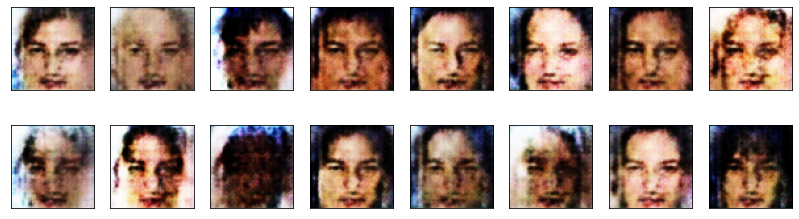

2023-11-14 12:11:07 | Epoch [18/25] | Batch 0/509 | d_loss: 1.3783 | g_loss: 0.8561
2023-11-14 12:11:11 | Epoch [18/25] | Batch 50/509 | d_loss: 1.4161 | g_loss: 0.7911
2023-11-14 12:11:16 | Epoch [18/25] | Batch 100/509 | d_loss: 1.4134 | g_loss: 0.7538
2023-11-14 12:11:21 | Epoch [18/25] | Batch 150/509 | d_loss: 1.4227 | g_loss: 0.7518
2023-11-14 12:11:26 | Epoch [18/25] | Batch 200/509 | d_loss: 1.3998 | g_loss: 0.8160
2023-11-14 12:11:30 | Epoch [18/25] | Batch 250/509 | d_loss: 1.4117 | g_loss: 0.7624
2023-11-14 12:11:35 | Epoch [18/25] | Batch 300/509 | d_loss: 1.3887 | g_loss: 0.8073
2023-11-14 12:11:40 | Epoch [18/25] | Batch 350/509 | d_loss: 1.4049 | g_loss: 0.8463
2023-11-14 12:11:45 | Epoch [18/25] | Batch 400/509 | d_loss: 1.4125 | g_loss: 0.8356
2023-11-14 12:11:49 | Epoch [18/25] | Batch 450/509 | d_loss: 1.4156 | g_loss: 0.7607
2023-11-14 12:11:54 | Epoch [18/25] | Batch 500/509 | d_loss: 1.4064 | g_loss: 0.8085


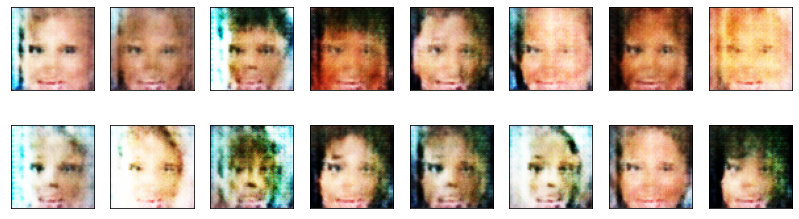

2023-11-14 12:11:59 | Epoch [19/25] | Batch 0/509 | d_loss: 1.3929 | g_loss: 0.7670
2023-11-14 12:12:04 | Epoch [19/25] | Batch 50/509 | d_loss: 1.4001 | g_loss: 0.7391
2023-11-14 12:12:08 | Epoch [19/25] | Batch 100/509 | d_loss: 1.3997 | g_loss: 0.7960
2023-11-14 12:12:13 | Epoch [19/25] | Batch 150/509 | d_loss: 1.4032 | g_loss: 0.7528
2023-11-14 12:12:18 | Epoch [19/25] | Batch 200/509 | d_loss: 1.4098 | g_loss: 0.7911
2023-11-14 12:12:23 | Epoch [19/25] | Batch 250/509 | d_loss: 1.3940 | g_loss: 0.7629
2023-11-14 12:12:28 | Epoch [19/25] | Batch 300/509 | d_loss: 1.4058 | g_loss: 0.7854
2023-11-14 12:12:32 | Epoch [19/25] | Batch 350/509 | d_loss: 1.3968 | g_loss: 0.7418
2023-11-14 12:12:37 | Epoch [19/25] | Batch 400/509 | d_loss: 1.3945 | g_loss: 0.7859
2023-11-14 12:12:41 | Epoch [19/25] | Batch 450/509 | d_loss: 1.4007 | g_loss: 0.8082
2023-11-14 12:12:46 | Epoch [19/25] | Batch 500/509 | d_loss: 1.4060 | g_loss: 0.7965


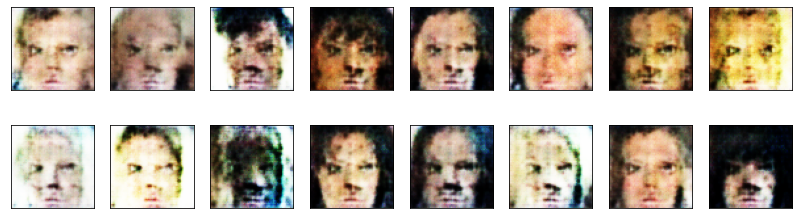

2023-11-14 12:12:50 | Epoch [20/25] | Batch 0/509 | d_loss: 1.3825 | g_loss: 0.8033
2023-11-14 12:12:55 | Epoch [20/25] | Batch 50/509 | d_loss: 1.4065 | g_loss: 0.8129
2023-11-14 12:13:00 | Epoch [20/25] | Batch 100/509 | d_loss: 1.3964 | g_loss: 0.8128
2023-11-14 12:13:05 | Epoch [20/25] | Batch 150/509 | d_loss: 1.4087 | g_loss: 0.8328
2023-11-14 12:13:09 | Epoch [20/25] | Batch 200/509 | d_loss: 1.3975 | g_loss: 0.8098
2023-11-14 12:13:14 | Epoch [20/25] | Batch 250/509 | d_loss: 1.4216 | g_loss: 0.7964
2023-11-14 12:13:19 | Epoch [20/25] | Batch 300/509 | d_loss: 1.3961 | g_loss: 0.7479
2023-11-14 12:13:23 | Epoch [20/25] | Batch 350/509 | d_loss: 1.4136 | g_loss: 0.7716
2023-11-14 12:13:28 | Epoch [20/25] | Batch 400/509 | d_loss: 1.3855 | g_loss: 0.8338
2023-11-14 12:13:33 | Epoch [20/25] | Batch 450/509 | d_loss: 1.3978 | g_loss: 0.7766
2023-11-14 12:13:38 | Epoch [20/25] | Batch 500/509 | d_loss: 1.4339 | g_loss: 0.8380


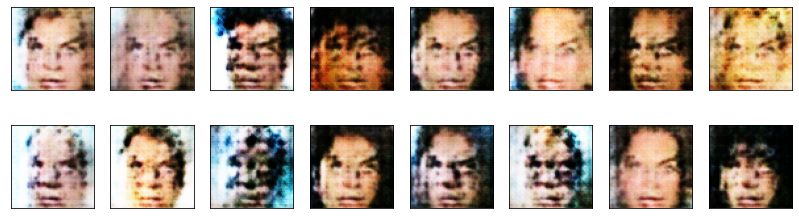

2023-11-14 12:13:42 | Epoch [21/25] | Batch 0/509 | d_loss: 1.3856 | g_loss: 0.7909
2023-11-14 12:13:47 | Epoch [21/25] | Batch 50/509 | d_loss: 1.3855 | g_loss: 0.7762
2023-11-14 12:13:52 | Epoch [21/25] | Batch 100/509 | d_loss: 1.3965 | g_loss: 0.8212
2023-11-14 12:13:56 | Epoch [21/25] | Batch 150/509 | d_loss: 1.3944 | g_loss: 0.7507
2023-11-14 12:14:01 | Epoch [21/25] | Batch 200/509 | d_loss: 1.4179 | g_loss: 0.8445
2023-11-14 12:14:05 | Epoch [21/25] | Batch 250/509 | d_loss: 1.3862 | g_loss: 0.8244
2023-11-14 12:14:10 | Epoch [21/25] | Batch 300/509 | d_loss: 1.3909 | g_loss: 0.7846
2023-11-14 12:14:14 | Epoch [21/25] | Batch 350/509 | d_loss: 1.3852 | g_loss: 0.7909
2023-11-14 12:14:19 | Epoch [21/25] | Batch 400/509 | d_loss: 1.3981 | g_loss: 0.7351
2023-11-14 12:14:23 | Epoch [21/25] | Batch 450/509 | d_loss: 1.4069 | g_loss: 0.8641
2023-11-14 12:14:28 | Epoch [21/25] | Batch 500/509 | d_loss: 1.3843 | g_loss: 0.7688


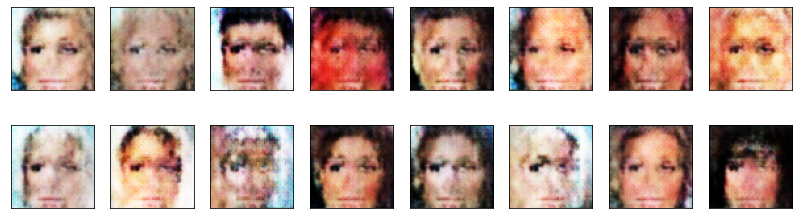

2023-11-14 12:14:32 | Epoch [22/25] | Batch 0/509 | d_loss: 1.3913 | g_loss: 0.7891
2023-11-14 12:14:37 | Epoch [22/25] | Batch 50/509 | d_loss: 1.4000 | g_loss: 0.8260
2023-11-14 12:14:41 | Epoch [22/25] | Batch 100/509 | d_loss: 1.3958 | g_loss: 0.8112
2023-11-14 12:14:46 | Epoch [22/25] | Batch 150/509 | d_loss: 1.4044 | g_loss: 0.7805
2023-11-14 12:14:50 | Epoch [22/25] | Batch 200/509 | d_loss: 1.3970 | g_loss: 0.7778
2023-11-14 12:14:55 | Epoch [22/25] | Batch 250/509 | d_loss: 1.3825 | g_loss: 0.7753
2023-11-14 12:14:59 | Epoch [22/25] | Batch 300/509 | d_loss: 1.3962 | g_loss: 0.8545
2023-11-14 12:15:04 | Epoch [22/25] | Batch 350/509 | d_loss: 1.3931 | g_loss: 0.7797
2023-11-14 12:15:09 | Epoch [22/25] | Batch 400/509 | d_loss: 1.3989 | g_loss: 0.8089
2023-11-14 12:15:14 | Epoch [22/25] | Batch 450/509 | d_loss: 1.4025 | g_loss: 0.7728
2023-11-14 12:15:18 | Epoch [22/25] | Batch 500/509 | d_loss: 1.3961 | g_loss: 0.8007


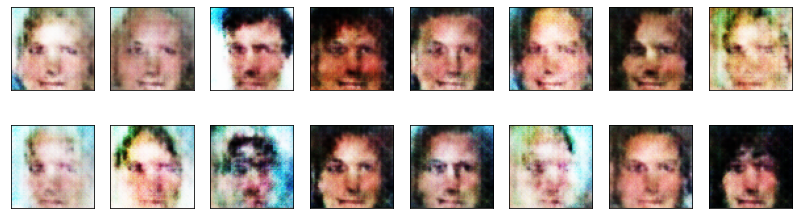

2023-11-14 12:15:23 | Epoch [23/25] | Batch 0/509 | d_loss: 1.3836 | g_loss: 0.7750
2023-11-14 12:15:27 | Epoch [23/25] | Batch 50/509 | d_loss: 1.3942 | g_loss: 0.7565
2023-11-14 12:15:32 | Epoch [23/25] | Batch 100/509 | d_loss: 1.4068 | g_loss: 0.7417
2023-11-14 12:15:37 | Epoch [23/25] | Batch 150/509 | d_loss: 1.3857 | g_loss: 0.7682
2023-11-14 12:15:42 | Epoch [23/25] | Batch 200/509 | d_loss: 1.3896 | g_loss: 0.8388
2023-11-14 12:15:47 | Epoch [23/25] | Batch 250/509 | d_loss: 1.3982 | g_loss: 0.7685
2023-11-14 12:15:51 | Epoch [23/25] | Batch 300/509 | d_loss: 1.4056 | g_loss: 0.8753
2023-11-14 12:15:56 | Epoch [23/25] | Batch 350/509 | d_loss: 1.3977 | g_loss: 0.7318
2023-11-14 12:16:01 | Epoch [23/25] | Batch 400/509 | d_loss: 1.3917 | g_loss: 0.8126
2023-11-14 12:16:06 | Epoch [23/25] | Batch 450/509 | d_loss: 1.4000 | g_loss: 0.7651
2023-11-14 12:16:10 | Epoch [23/25] | Batch 500/509 | d_loss: 1.3917 | g_loss: 0.8136


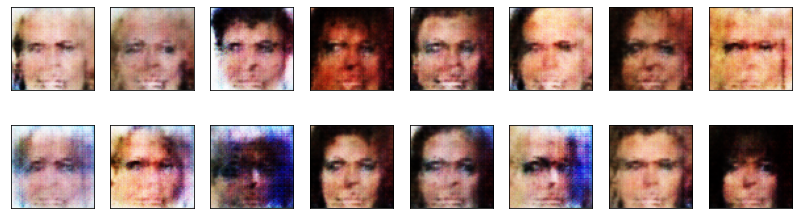

2023-11-14 12:16:15 | Epoch [24/25] | Batch 0/509 | d_loss: 1.3761 | g_loss: 0.7984
2023-11-14 12:16:19 | Epoch [24/25] | Batch 50/509 | d_loss: 1.3838 | g_loss: 0.7505
2023-11-14 12:16:24 | Epoch [24/25] | Batch 100/509 | d_loss: 1.3928 | g_loss: 0.7957
2023-11-14 12:16:28 | Epoch [24/25] | Batch 150/509 | d_loss: 1.4057 | g_loss: 0.8756
2023-11-14 12:16:32 | Epoch [24/25] | Batch 200/509 | d_loss: 1.3942 | g_loss: 0.7018
2023-11-14 12:16:37 | Epoch [24/25] | Batch 250/509 | d_loss: 1.3933 | g_loss: 0.7846
2023-11-14 12:16:41 | Epoch [24/25] | Batch 300/509 | d_loss: 1.3990 | g_loss: 0.7632
2023-11-14 12:16:45 | Epoch [24/25] | Batch 350/509 | d_loss: 1.3952 | g_loss: 0.7330
2023-11-14 12:16:50 | Epoch [24/25] | Batch 400/509 | d_loss: 1.3884 | g_loss: 0.7459
2023-11-14 12:16:54 | Epoch [24/25] | Batch 450/509 | d_loss: 1.3966 | g_loss: 0.7472
2023-11-14 12:16:59 | Epoch [24/25] | Batch 500/509 | d_loss: 1.3883 | g_loss: 0.7622


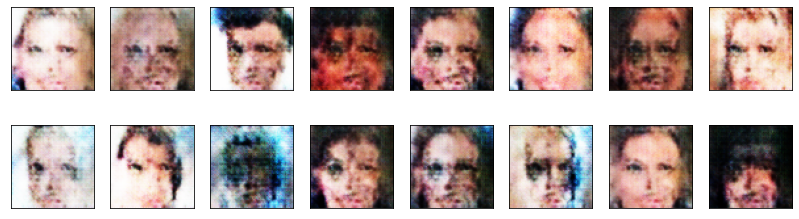

2023-11-14 12:17:02 | Epoch [25/25] | Batch 0/509 | d_loss: 1.3839 | g_loss: 0.7531
2023-11-14 12:17:07 | Epoch [25/25] | Batch 50/509 | d_loss: 1.3927 | g_loss: 0.7307
2023-11-14 12:17:11 | Epoch [25/25] | Batch 100/509 | d_loss: 1.3931 | g_loss: 0.8325
2023-11-14 12:17:16 | Epoch [25/25] | Batch 150/509 | d_loss: 1.3978 | g_loss: 0.7580
2023-11-14 12:17:20 | Epoch [25/25] | Batch 200/509 | d_loss: 1.3910 | g_loss: 0.7874
2023-11-14 12:17:24 | Epoch [25/25] | Batch 250/509 | d_loss: 1.3899 | g_loss: 0.8203
2023-11-14 12:17:29 | Epoch [25/25] | Batch 300/509 | d_loss: 1.3803 | g_loss: 0.7953
2023-11-14 12:17:33 | Epoch [25/25] | Batch 350/509 | d_loss: 1.3950 | g_loss: 0.7296
2023-11-14 12:17:38 | Epoch [25/25] | Batch 400/509 | d_loss: 1.3820 | g_loss: 0.8008
2023-11-14 12:17:42 | Epoch [25/25] | Batch 450/509 | d_loss: 1.3954 | g_loss: 0.8299
2023-11-14 12:17:46 | Epoch [25/25] | Batch 500/509 | d_loss: 1.3885 | g_loss: 0.7711


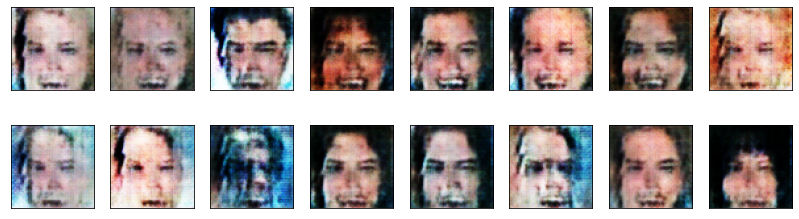

In [33]:
# adding noise to 
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        # important rescaling step ==> even worse
        # real_images = scale(real_images)
        
        ####################################

        # TODO: implement the training strategy
        if train_on_gpu:
            discriminator.cuda()
            generator.cuda()
        
        batch_size = real_images.size(0)
        # With real image
        if train_on_gpu:
            real_images= real_images.cuda()
    
        
        if batch_i % 4 == 0:
            d_loss= discriminator_step(batch_size, latent_dim, real_images)
        g_loss= generator_step(batch_size, latent_dim)
        
         
        ####################################
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

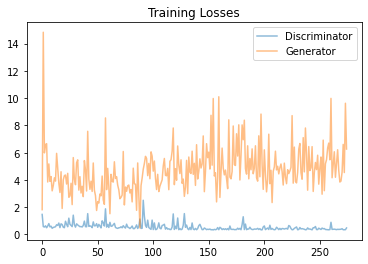

In [35]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** (Write your answer in this cell)

* obviously, loss function didn't converge. We need to consider grident penalty. Or increase model size of generator.
* face generated seems mixed with sex and skin color, we need better classified dataset to training.
* Epoch number seems have not too much influence when above 8


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.